# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [1]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'], labels, test_size=0.2)

### Prep Data For Modeling

In [2]:
# Install keras
!pip install keras

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [4]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [5]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
# What do these sequences look like?
print(len(X_train_seq), len(X_train_seq[0]))
print(X_train_seq[0])

4457 6
[364, 2555, 518, 134, 463, 6]


In [7]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [8]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        364, 2555,  518,  134,  463,    6])

### Build Model

In [9]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [10]:
# Construct a simple RNN model
model = Sequential([
    Embedding(len(tokenizer.index_word)+1, 32),
    LSTM(32, dropout=0.5, recurrent_dropout=0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          253760    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 263,169
Trainable params: 263,169
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [12]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10, verbose=2,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 - 5s - loss: 0.2723 - accuracy: 0.9082 - precision_m: 0.4742 - recall_m: 0.3838 - val_loss: 0.0888 - val_accuracy: 0.9704 - val_precision_m: 0.9714 - val_recall_m: 0.8014 - 5s/epoch - 33ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0389 - accuracy: 0.9899 - precision_m: 0.9763 - recall_m: 0.9360 - val_loss: 0.0491 - val_accuracy: 0.9874 - val_precision_m: 0.9905 - val_recall_m: 0.9335 - 2s/epoch - 16ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0166 - accuracy: 0.9955 - precision_m: 0.9898 - recall_m: 0.9657 - val_loss: 0.0577 - val_accuracy: 0.9865 - val_precision_m: 0.9943 - val_recall_m: 0.9222 - 2s/epoch - 18ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0073 - accuracy: 0.9982 - precision_m: 0.9614 - recall_m: 0.9546 - val_loss: 0.0645 - val_accuracy: 0.9857 - val_precision_m: 0.9762 - val_recall_m: 0.9335 - 2s/epoch - 17ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0044 - accuracy: 0.9989 - precision_m: 0.9847 - recall_m: 0.9798 - val_loss: 0.0681 - val_accuracy: 0.9865 - val_p

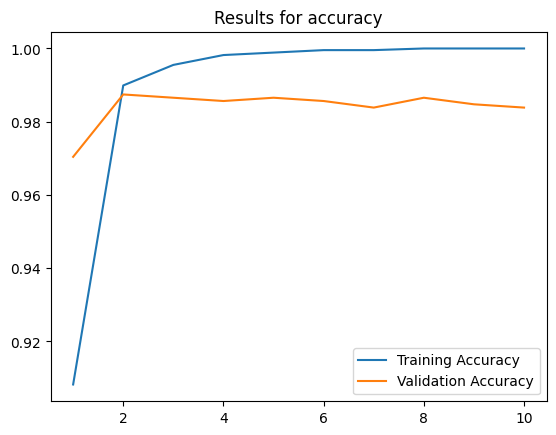

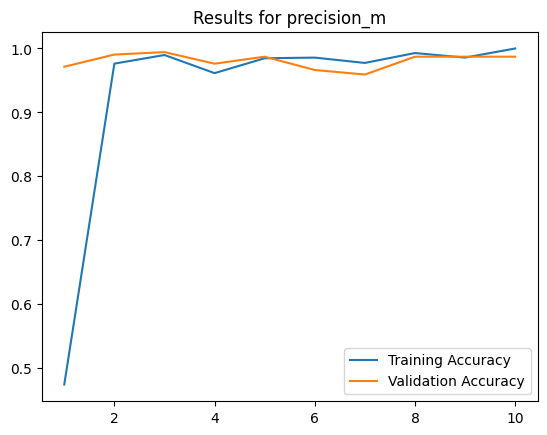

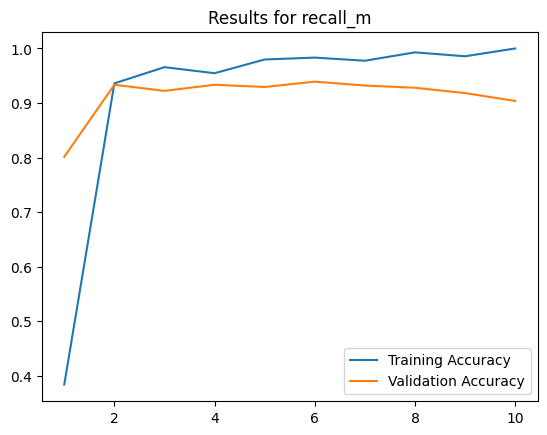

In [13]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()